In [1]:
import os
import sys
sys.path.append("../")
from mixup import Mixup

from PIL import Image
import torch
import torchvision.transforms as T

import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot(imgs, imgs_titles=None, figsize=(10, 4), **imshow_kwargs):
    # Make a 2d grid even if there's just 1 row
    if not isinstance(imgs[0], list):
        imgs = [imgs]
    if imgs_titles:
        if not isinstance(imgs_titles[0], list):
            imgs_titles = [imgs_titles]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    fig, axs = plt.subplots(
        nrows=num_rows, 
        ncols=num_cols, 
        squeeze=False, 
        figsize=figsize, 
    )
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs) # same as `np.asarray()`
            # ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
            ax.axis("off")
            if imgs_titles is not None:
                ax.set(title="{}".format(imgs_titles[row_idx][col_idx]))
            else:
                ax.set(title="{}".format(img.size))

    plt.tight_layout()

In [3]:
raw_image_paths = [
   "../../static/images/n02085936_Maltese_dog.jpeg",
   "../../static/images/n02086079_Pekinese_dog.jpeg",
   "../../static/images/n02123394_Persian_cat.jpeg",
   "../../static/images/n02124075_Egyptian_cat.jpeg",
]
label_dict = {
    "dog": 0,
    "cat": 1,
}

pil_images = [Image.open(image_path) for image_path in raw_image_paths]
raw_labels = [
    label_dict[
        os.path.basename(image_path).replace(".jpeg", "").split("_")[-1]
    ] 
    for image_path in raw_image_paths
]

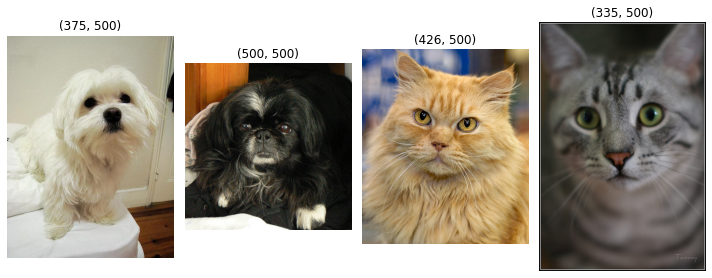

In [4]:
plot(pil_images)

In [5]:
norm_mean = (0.485, 0.456, 0.406)
norm_std = (0.229, 0.224, 0.225) 

def denormalize(x, mean=norm_mean, std=norm_std):
    """Input x (shape): B x C x H x W"""
    ten = x.clone().permute(1, 2, 3, 0) # C, H, W, B
    for t, m, s in zip(ten, mean, std):
        t.mul_(s).add_(m)
    
    return torch.clamp(ten, 0, 1).permute(3, 0, 1, 2) # B, C, H, W

# def denorm_input(inp, mean=norm_mean, std=norm_std):
#     """Imshow for Tensor."""
#     inp = inp.numpy().transpose((1, 2, 0))
#     mean_ = np.array(mean)
#     std_ = np.array(std)
#     inp = std * inp + mean
#     inp = np.clip(inp, 0, 1)

#     return inp
    
resize_and_totensor_trans = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(norm_mean, norm_std),
])

In [6]:
mixup_fn = Mixup(
    mixup_alpha=1.0, cutmix_alpha=0.8, mode="batch", num_classes=2
)

The alpha value for `cutmix` and `mixup` is to sample a random value from Beta distribution. 

A visualization of beta distribution: https://www.wolframalpha.com/input/?i=beta+distribution+%280.8%2C+0.8%29

Both data augmentation used symmetric value for beta distribution. 

In [7]:
def run_mix_up():
    mixup_fn = Mixup(
        mixup_alpha=0.8, 
        cutmix_alpha=1.0, 
        mode="batch", 
        num_classes=2
    )
    image_data = torch.stack([resize_and_totensor_trans(img_) for img_ in pil_images])
    label_data = torch.tensor(raw_labels)
    sampled_image_, sampled_targets_ = mixup_fn(image_data, label_data)

    labels_ = sampled_targets_.detach().numpy()

    plot(
        [
            T.ToPILImage()(denormalize(sampled_image_[i].unsqueeze(0)).squeeze(0))
            for i in range(sampled_image_.shape[0])
        ],
        imgs_titles=[str(l) for l in labels_]
    )

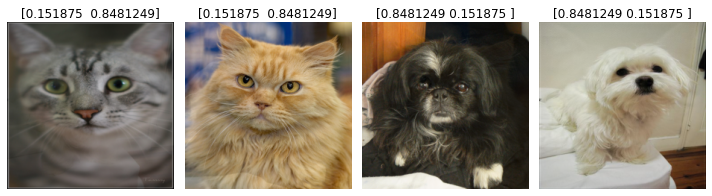

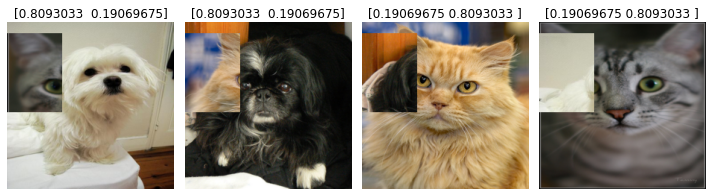

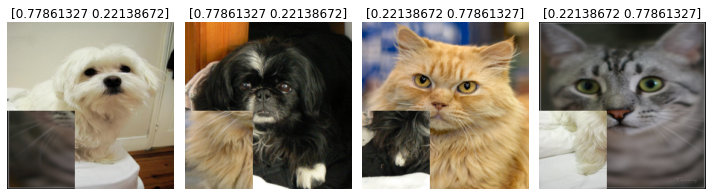

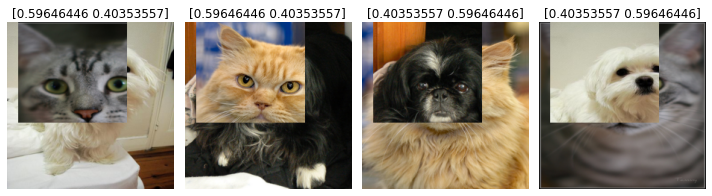

In [8]:
_ = [run_mix_up() for _ in range(4)]